In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display

import tensorflow as tf
print(tf. __version__)

from SQ_decoder import SQ_decoder, to_tf

2.10.0


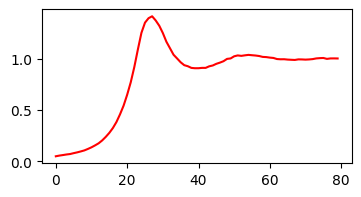

In [2]:
z_example = to_tf([0.159027  ,  0.14598719,  0.4])
SQ_example = SQ_decoder(z_example)
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(1,1,1)
ax.plot(SQ_example,'-r')
plt.show()

In [3]:
# define class VAE
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [4]:
# load pre-trained decoder
@tf.function
def f_out_tf(sq_pred):
    return tf.math.exp((sq_pred*2-1)*exp_scale)

latent_dim = 3
q_rs_dim = 80
model = VAE(latent_dim, q_rs_dim)

export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
model_r = reload_sm._root
decoder_loaded = model_r.decoder
decoder_loaded.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_4 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 80, 32)           3104      
 se)                                                             
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 80, 1)            97        
 ranspose)                                                       
                                                                 
 reshape_5 (Reshape)         (None, 80)                0         
                                                                 
Total params: 8,321
Trainable params: 8,321
Non-traina

In [5]:
# freeze loaded layers
for i, layers in enumerate(decoder_loaded.layers):
        decoder_loaded.layers[i].trainable = False

# Add a dense layer to pre-trained decoder
regularizer = tf.keras.regularizers.L2(5e-2)
dense_3 = [
    tf.keras.layers.InputLayer(input_shape=(3)),
    tf.keras.layers.Dense(24, 
                kernel_regularizer = regularizer,
                name='dense_in'),
    tf.keras.layers.Dense(3, 
                kernel_regularizer = None,
                name='dense_in2'),]

# rescaling the dense layer to the value range of decoder input
rescale = [tf.keras.layers.Rescaling(scale=6.0, offset=0.0)]
rescale[0].trainable = False

decoder_aug_layers = dense_3+rescale+decoder_loaded.layers
decoder_aug = tf.keras.Sequential(decoder_aug_layers)
decoder_aug.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_in (Dense)            (None, 24)                96        
                                                                 
 dense_in2 (Dense)           (None, 3)                 75        
                                                                 
 rescaling (Rescaling)       (None, 3)                 0         
                                                                 
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_4 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 80, 32)           3104      
 se)                                                             
                                                      

## Load data

In [6]:
parameters_zscore = 1

In [7]:
# Training set
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


In [8]:
# Test set
if 0:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

# normalization
eta_test_z = (eta_test-eta_mean)/eta_std
kappa_test_z = (kappa_test-kappa_mean)/kappa_std
A_test_z = (A_test-A_mean)/A_std

if parameters_zscore:
    parameters_test = np.array([eta_test_z,kappa_test_z,A_test_z]).T
else:
    parameters_test = np.array([eta_test,kappa_test,A_test]).T

sample_test_dim = sq_test.shape[0]

# Rescale
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],fill_value='extrapolate')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta_test),np.var(eta_test)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa_test),np.var(kappa_test)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A_test),np.var(A_test)))

eta ~ N(0.2301,0.0157)
kappa ~ N(0.2595,0.0193)
A ~ N(12.9685,48.1309)


Preprocess/Postprocess

In [9]:
# Mask
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

# rescale the training set SQ to range [0,1]
exp_scale = 6
def f_inp(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

# transform the decoder output to SQ
def f_out_sample(x):
    return f_out_tf(tf.sigmoid(x))

# rescale the fitting parameters to range [0,1]
def fp_inp(parameters):
    return np.log(parameters)/exp_scale/2

def fp_out(parameters_pred):
    return np.exp((parameters_pred*2)*exp_scale)

def f_out(sq_pred):
    return np.exp((sq_pred*2-1)*exp_scale) # inverse of f_inp

# def f_inp2(sq):
#     return np.log(sq/4.5)/1.5/2 + 0.5

# def f_out2(sq_pred):
#     return tf.math.exp((sq_pred*2-1)*1.5)*4.5


## Shuffle data

In [10]:
# Merge sets
train_size = sq.shape[0]
test_size = sq_test.shape[0]
print('training set size = {} \ntest set size = {}'.format(train_size,test_size))
    
batch_size = 64
batch_size_test = 1000

train_SQ_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_mask))
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_SQ_dataset = (tf.data.Dataset.from_tensor_slices(f_inp(sq_test_mask))
                .shuffle(test_size, seed=6174).batch(batch_size_test))

train_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_train))
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_test))
                .shuffle(test_size, seed=6174).batch(batch_size_test))

training set size = 18750 
test set size = 15000


## Define loss function and optimizer

In [11]:
# regularization loss
def loss_l1(weights):
    loss = tf.reduce_mean(tf.math.abs(weights))
    return loss

def loss_l2(weights):
    loss = tf.reduce_mean((weights)**2)
    return loss

Optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-2)

def compute_loss(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    err = tf.reduce_mean((f_inp(f_out_sample(model(parameters)))-SQ)**2)
    
    return err

@tf.function
def train_step(parameters, SQ, model, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(parameters, SQ, model)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [13]:
epochs = 250
model = decoder_aug
num_examples_to_generate = 16
num_examples_to_validate = 1000

In [14]:
# Pick a sample of the test set for generating output images
assert batch_size_test >= num_examples_to_generate
# for test_SQ_batch in train_SQ_dataset.take(1):
#     test_SQ_sample = test_SQ_batch[0:num_examples_to_generate, :]
# for test_parameters_batch in train_parameters_dataset.take(1):
#     test_parameters_sample = test_parameters_batch[0:num_examples_to_generate, :]
    
# no random
i = 0
for test_SQ_batch in train_SQ_dataset:
    if i == 6:
        test_SQ_sample = test_SQ_batch[0:num_examples_to_generate, :]
    i+=1
i = 0
for test_parameters_batch in train_parameters_dataset:
    if i == 6:
        test_parameters_sample = test_parameters_batch[0:num_examples_to_generate, :]
    i+=1

In [15]:
# validation dataset
for validate_SQ_batch in test_SQ_dataset.take(1):
    validate_SQ_sample = validate_SQ_batch[0:num_examples_to_validate, :]
for validate_parameters_batch in test_parameters_dataset.take(1):
    validate_parameters_sample = validate_parameters_batch[0:num_examples_to_validate, :]

# # no random
# i = 0
# for validate_SQ_batch in test_SQ_dataset:
#     if i == 6:
#         validate_SQ_sample = validate_SQ_batch[0:num_examples_to_validate, :]
#     i+=1
# i = 0
# for validate_parameters_batch in test_parameters_dataset:
#     if i == 6:
#         validate_parameters_sample = validate_parameters_batch[0:num_examples_to_validate, :]
#     i+=1

In [16]:
def generate_and_save_images(model, epoch, test_SQ_sample, test_parameters_sample):
    GT = f_out(test_SQ_sample)
    predictions = f_out_sample(model(test_parameters_sample))
        
    fig = plt.figure(figsize=(8, 8))

    for i in range(GT.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.plot(q_rs,GT[i,:],'k')
        plt.plot(q_rs,predictions[i,:],'.c')    
        
        #plt.axis('off')
        plt.ylim(0, 3)

    # tight_layout minimizes the overlap between 2 sub-plots
    pngname = './figures/{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.show()

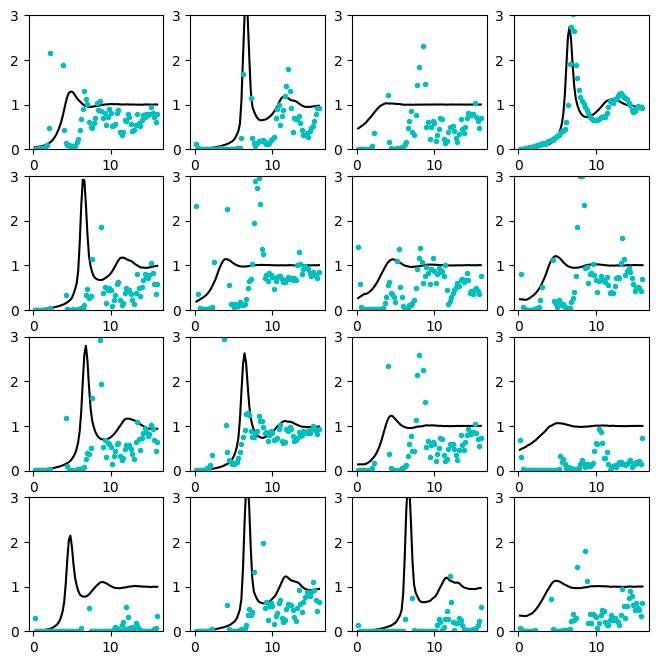

In [17]:
generate_and_save_images(model, 0, test_SQ_sample, test_parameters_sample)

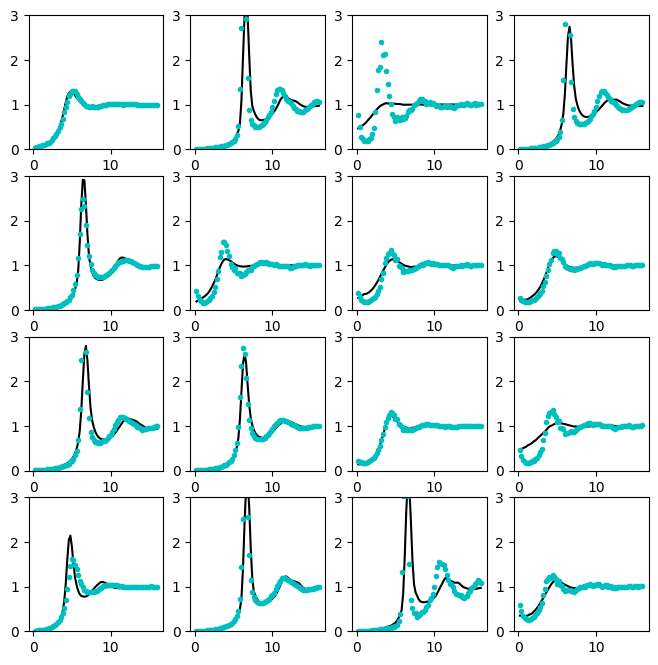

100%|████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:30<00:00,  1.80s/it]


In [18]:
err_test_epoch = np.zeros(epochs)
err_train_epoch = np.zeros(epochs)
err_validate_epoch = np.zeros(epochs)
for epoch in tqdm(range(1, epochs + 1)):
    # training set
    for train_SQ_batch in train_SQ_dataset.take(1):
        train_SQ = train_SQ_batch[0:batch_size, :]
    for train_parameters_batch in train_parameters_dataset.take(1):
        train_parameters = train_parameters_batch[0:batch_size, :]
        
    # test set    
    for test_SQ_batch in test_SQ_dataset.take(1):
        test_SQ = test_SQ_batch[0:batch_size_test, :]
    for test_parameters_batch in test_parameters_dataset.take(1):
        test_parameters = test_parameters_batch[0:batch_size_test, :]
        
    # validation set
    for validate_SQ_batch in test_SQ_dataset.take(1):
        validate_SQ = validate_SQ_batch[0:num_examples_to_validate, :]
    for validate_parameters_batch in test_parameters_dataset.take(1):
        validate_parameters = validate_parameters_batch[0:num_examples_to_validate, :]
    
    start_time = time.time()
    train_step(train_parameters, train_SQ, model, optimizer)    
    end_time = time.time()
    
    # loss
    err_test = compute_loss(test_parameters, test_SQ, model)
    err_train = compute_loss(train_parameters, train_SQ, model)
    err_validate = compute_loss(validate_parameters, validate_SQ, model)
    err_test_epoch[epoch-1] = err_test
    err_train_epoch[epoch-1] = err_train
    err_validate_epoch[epoch-1] = err_validate
        
    display.clear_output(wait=0.5)
#     print('Epoch: {}, Test set ELBO: {:.6}, err:{:.6}, time elapse for current epoch: {}'.format(epoch, elbo, err_train, end_time - start_time))
    generate_and_save_images(model, epoch, test_SQ_sample, test_parameters_sample)

In [19]:
anim_file = './test.gif'

import glob
import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures/*.png')
    filenames = sorted(filenames)
    i == 0
    for filename in filenames:
        if i%5==0:
            image = imageio.imread(filename)
            writer.append_data(image)
        i+=1
    image = imageio.imread(filename)
    writer.append_data(image)

In [20]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_in (Dense)            (None, 24)                96        
                                                                 
 dense_in2 (Dense)           (None, 3)                 75        
                                                                 
 rescaling (Rescaling)       (None, 3)                 0         
                                                                 
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_4 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 80, 32)           3104      
 se)                                                             
                                                      

In [21]:
layer0 = model.layers[1]
layer0.get_weights()

[array([[ 0.25282958,  0.09125645, -0.27905872],
        [ 0.29735637,  0.23657869,  0.36337844],
        [ 0.27751797,  0.19112949, -0.2045137 ],
        [ 0.06606216,  0.26829135, -0.30086222],
        [-0.05409705, -0.12928233, -0.17965297],
        [-0.4425026 , -0.12402704,  0.35388246],
        [-0.24275468, -0.08040816,  0.02846073],
        [ 0.06707594,  0.12067182,  0.14536254],
        [ 0.10522006,  0.05888096, -0.27783677],
        [ 0.14762005, -0.22607884,  0.15723531],
        [ 0.24604729,  0.06154371,  0.32932168],
        [-0.12863705, -0.21633494, -0.17797583],
        [-0.20180959,  0.13810885, -0.140706  ],
        [ 0.3104188 , -0.45737854, -0.34092084],
        [ 0.18217118, -0.3930981 , -0.47472006],
        [ 0.29129735,  0.10312582,  0.28494218],
        [ 0.21352972,  0.16519015, -0.38709605],
        [ 0.1687598 , -0.18903512,  0.24382274],
        [ 0.1283881 ,  0.02476819,  0.22227415],
        [-0.07284257,  0.10924041, -0.24319737],
        [-0.05681538

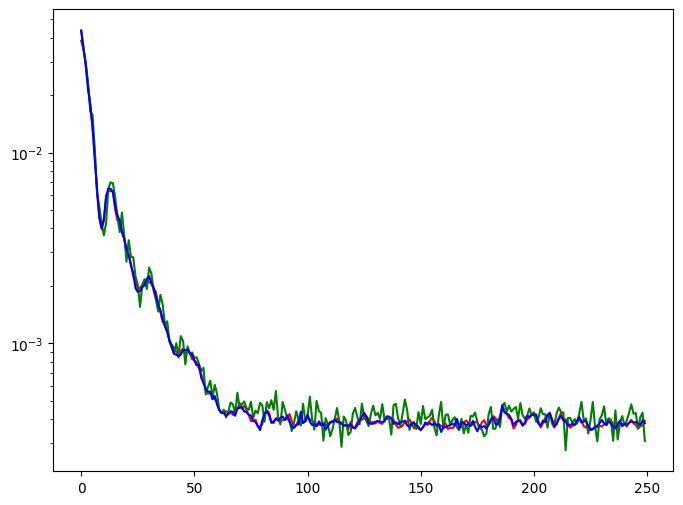

In [22]:
errname = './figures/test_err.png'
fig2 = plt.figure(figsize=(8, 6))
plt.plot(err_test_epoch,'-r')
plt.plot(err_train_epoch,'-g')
plt.plot(err_validate_epoch,'-b')
plt.yscale('log')
#plt.ylim(4e-3, 1e-1)
plt.savefig(errname.format(epoch))
plt.show()

In [23]:
# unfreeze layers
for i, layers in enumerate(model.layers):
        model.layers[i].trainable = True

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_in (Dense)            (None, 24)                96        
                                                                 
 dense_in2 (Dense)           (None, 3)                 75        
                                                                 
 rescaling (Rescaling)       (None, 3)                 0         
                                                                 
 dense_de (Dense)            (None, 1280)              5120      
                                                                 
 reshape_4 (Reshape)         (None, 40, 32)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 80, 32)           3104      
 se)                                                             
                                                      

In [24]:
def generate_and_save_images_tune(model, epoch, test_SQ_sample, test_parameters_sample):
    GT = f_out(test_SQ_sample)
    predictions = f_out_sample(model(test_parameters_sample))
        
    fig = plt.figure(figsize=(8, 8))

    for i in range(GT.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.plot(q_rs,GT[i,:],'k')
        plt.plot(q_rs,predictions[i,:],'.c')    
        
        #plt.axis('off')
        plt.ylim(0, 3)

    # tight_layout minimizes the overlap between 2 sub-plots
    pngname = './figures/{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.show()

In [25]:
optimizer = tf.keras.optimizers.Adam(2e-4)

def compute_loss(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    err = tf.reduce_mean((f_inp(f_out_sample(model(parameters)))-SQ)**2)
    
    return err

@tf.function
def train_step_ft(parameters, SQ, model, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(parameters, SQ, model)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

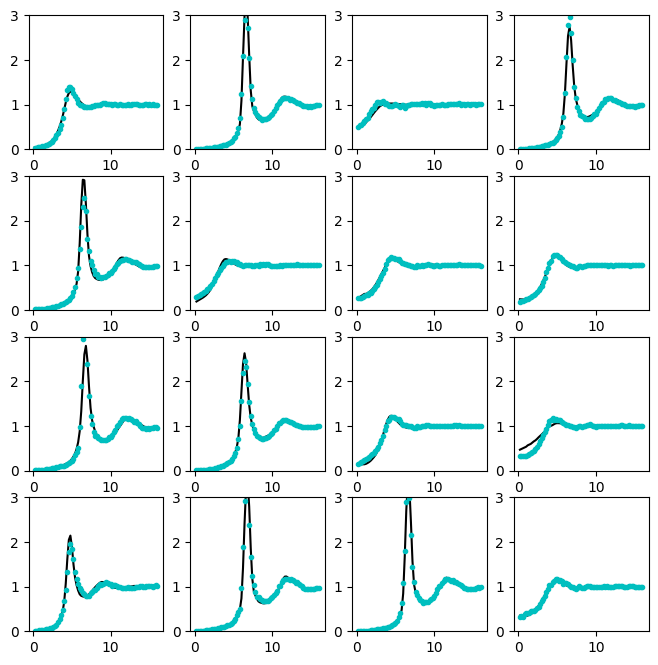

100%|████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:56<00:00,  1.90s/it]


In [26]:
err_test_epoch_ft = np.zeros(epochs)
err_train_epoch_ft = np.zeros(epochs)
err_validate_epoch_ft = np.zeros(epochs)
for epoch in tqdm(range(1, epochs + 1)):
    # training set
    for train_SQ_batch in train_SQ_dataset.take(1):
        train_SQ = train_SQ_batch[0:batch_size, :]
    for train_parameters_batch in train_parameters_dataset.take(1):
        train_parameters = train_parameters_batch[0:batch_size, :]
        
    # test set    
    for test_SQ_batch in test_SQ_dataset.take(1):
        test_SQ = test_SQ_batch[0:batch_size_test, :]
    for test_parameters_batch in test_parameters_dataset.take(1):
        test_parameters = test_parameters_batch[0:batch_size_test, :]
        
    # validation set
    for validate_SQ_batch in test_SQ_dataset.take(1):
        validate_SQ = validate_SQ_batch[0:num_examples_to_validate, :]
    for validate_parameters_batch in test_parameters_dataset.take(1):
        validate_parameters = validate_parameters_batch[0:num_examples_to_validate, :]
    
    start_time = time.time()
    train_step_ft(train_parameters, train_SQ, model, optimizer)    
    end_time = time.time()
    
    # loss
    err_test = compute_loss(test_parameters, test_SQ, model)
    err_train = compute_loss(train_parameters, train_SQ, model)
    err_validate = compute_loss(validate_parameters, validate_SQ, model)
    err_test_epoch_ft[epoch-1] = err_test
    err_train_epoch_ft[epoch-1] = err_train
    err_validate_epoch_ft[epoch-1] = err_validate
        
    display.clear_output(wait=0.5)
#     print('Epoch: {}, Test set ELBO: {:.6}, err:{:.6}, time elapse for current epoch: {}'.format(epoch, elbo, err_train, end_time - start_time))
    generate_and_save_images_tune(model, epoch+epochs, test_SQ_sample, test_parameters_sample)

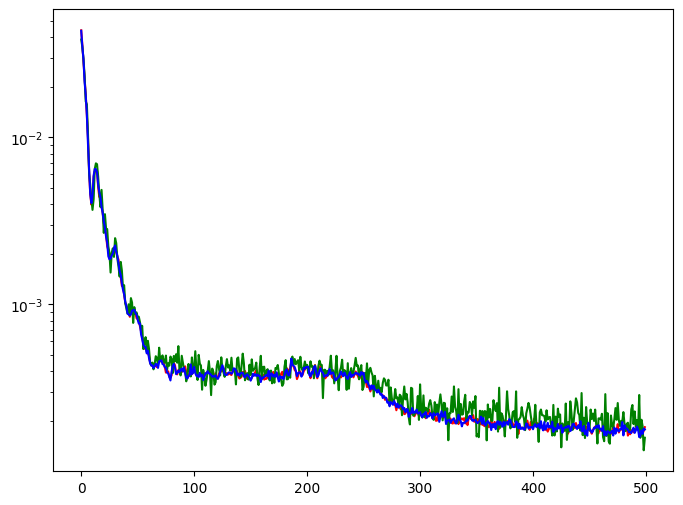

In [27]:
err_test_all = np.hstack((err_test_epoch,err_test_epoch_ft))
err_train_all = np.hstack((err_train_epoch,err_train_epoch_ft))
err_validate_all = np.hstack((err_validate_epoch,err_validate_epoch_ft))
errname = './figures/test_err_ft.png'
fig2 = plt.figure(figsize=(8, 6))
plt.plot(err_test_all,'-r')
plt.plot(err_train_all,'-g')
plt.plot(err_validate_all,'-b')
plt.yscale('log')
#plt.ylim(4e-3, 1e-1)
plt.savefig(errname.format(epoch))
plt.show()

In [28]:
anim_file = './test_ft.gif'

import glob
import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures/*.png')
    filenames = sorted(filenames)
    i == 0
    for filename in filenames:
        if i%5==0:
            image = imageio.imread(filename)
            writer.append_data(image)
        i+=1
    image = imageio.imread(filename)
    writer.append_data(image)